In [1]:
# parameters
mcd_path = "/home/jovyan/shared_data/data/earthdata/MCD19A2.06/"
output_path = "/home/jovyan/shared_materials/challenge_2_data/MCD19A2/"

target_lon_bds = (-28.0, -12.0)
target_lon_diff = 0.25
target_lat_bds = (8.0, 20.0)
target_lat_diff = 0.25

In [2]:
from pathlib import Path
import xarray as xr
import numpy as np
import rasterio

from datetime import datetime, timedelta

import warnings
import tqdm

See https://rasterio.groups.io/g/main/topic/reading_hdf4_files_with/36311624

In [3]:
mcd_files = sorted(Path(mcd_path).glob("MCD*.hdf"))
print(len(mcd_files))

11722


In [4]:
def get_timestamp_from_filename(fname):
    try:
        fname = fname.name
    except AttributeError as e:
        pass
    year_day = fname.split(".")[1][1:]
    year = int(year_day[:4])
    day = int(year_day[-3:])
    return datetime(year, 1, 1, 0, 0, 0) + timedelta(days=day - 1)

In [5]:
def test_get_timestamp_from_filename():
    fname = "MCD19A2.A2024065.h18v09.061.2024066175245.hdf"
    true_timestamp = datetime(2024, 3, 5, 0, 0)
    computed_timestamp = get_timestamp_from_filename(fname)
    assert computed_timestamp == true_timestamp

In [6]:
test_get_timestamp_from_filename()

In [7]:
def open_optical_depth(fname):
    # open subdatasets for optical depth and rename accordingly
    rio_ds = rasterio.open(fname)
    optical_depth_subsets = [sds for sds in rio_ds.subdatasets if "Optical_Depth" in sds]
    xr_ds = {
        sds.split(":")[-1]: xr.open_dataset(sds, engine="rasterio") for sds in optical_depth_subsets
    }
    xr_ds = {
        k: v.rename({"band_data": k}) for k, v in xr_ds.items()
    }

    # transform lat lon
    for k, _ds in xr_ds.items():
        _lon, _lat = rasterio.warp.transform(
            _ds.rio.crs,
                {'init': 'EPSG:4326'},
                _ds.x.data.flatten(),
                _ds.y.data.flatten(),
        )
        xr_ds[k] = _ds.assign_coords(
            lon=(("x", ), _lon),
            lat=(("y", ), _lat),
        )

    # merge
    merged_ds = xr.merge(xr_ds.values())

    # add timestamp
    merged_ds = merged_ds.assign_coords(
        time=((), get_timestamp_from_filename(fname)),
    )
    
    return merged_ds

In [8]:
import pandas as pd

In [9]:
def get_outline(fname):
    ds = open_optical_depth(fname)
    lon0, lon1, lat0, lat1 = [
        ds.lon.min().data[()],
        ds.lon.max().data[()],
        ds.lat.min().data[()],
        ds.lat.max().data[()]
    ]
    return pd.DataFrame(
        dict(lon_min=lon0, lon_max=lon1, lat_min=lat0, lat_max=lat1),
        index=[fname.name, ]
    )

In [10]:
_dfs = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for _f in tqdm.tqdm(mcd_files):
        try:
            _dfs.append(get_outline(_f))
        except Exception as e:
            pass
    
df_outlines = pd.concat(_dfs)

100%|██████████| 11722/11722 [07:17<00:00, 26.79it/s]


In [11]:
from shapely.geometry import Polygon, Point

In [12]:
_ll = list(map(Point, zip(df_outlines["lon_min"], df_outlines["lat_min"])))
_lr = list(map(Point, zip(df_outlines["lon_max"], df_outlines["lat_min"])))
_ul = list(map(Point, zip(df_outlines["lon_min"], df_outlines["lat_max"])))
_ur = list(map(Point, zip(df_outlines["lon_max"], df_outlines["lat_max"])))
_poly = list(map(Polygon, zip(_ll, _lr, _ur, _ul)))

In [13]:
import geopandas as gpd

In [14]:
outlines_df = gpd.GeoDataFrame(geometry=gpd.GeoSeries(_poly, index=df_outlines.index))

In [15]:
import cartopy
from matplotlib import pyplot as plt

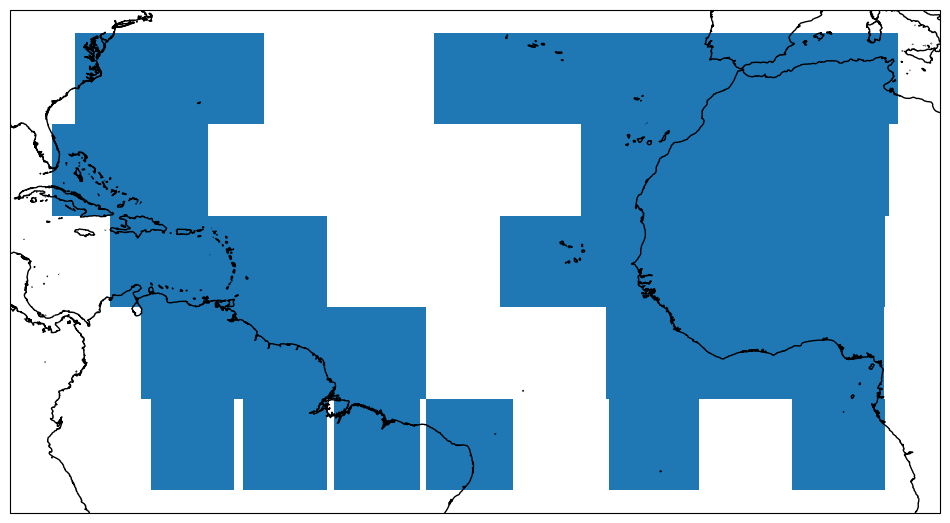

In [16]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": cartopy.crs.PlateCarree()}, figsize=(12, 12))

outlines_df.plot(alpha=0.002, transform=cartopy.crs.PlateCarree(), ax=ax)
ax.coastlines("10m");

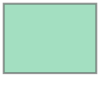

In [17]:
target_poly_ll = (target_lon_bds[0], target_lat_bds[0])
target_poly_lr = (target_lon_bds[1], target_lat_bds[0])
target_poly_ur = (target_lon_bds[1], target_lat_bds[1])
target_poly_ul = (target_lon_bds[0], target_lat_bds[1])
target_poly = Polygon([target_poly_ll, target_poly_lr, target_poly_ur, target_poly_ul])
target_poly

In [18]:
mcd_files_of_interest = [Path(mcd_path) / _f for _f in outlines_df.where(outlines_df.geometry.intersects(target_poly)).dropna().index]
mcd_files_of_interest[:5]

[PosixPath('/home/jovyan/shared_data/data/earthdata/MCD19A2.06/MCD19A2.A2022363.h15v07.061.2023013111218.hdf'),
 PosixPath('/home/jovyan/shared_data/data/earthdata/MCD19A2.06/MCD19A2.A2022363.h16v07.061.2023013213838.hdf'),
 PosixPath('/home/jovyan/shared_data/data/earthdata/MCD19A2.06/MCD19A2.A2022363.h16v08.061.2023013111839.hdf'),
 PosixPath('/home/jovyan/shared_data/data/earthdata/MCD19A2.06/MCD19A2.A2022364.h15v07.061.2023013122525.hdf'),
 PosixPath('/home/jovyan/shared_data/data/earthdata/MCD19A2.06/MCD19A2.A2022364.h16v07.061.2023013221940.hdf')]

In [19]:
from xhistogram.xarray import histogram as xhist

In [20]:
lon_bin_edges = np.arange(
    target_lon_bds[0] - target_lon_diff,
    target_lon_bds[1] + 2 * target_lon_diff,
    target_lon_diff
)
lat_bin_edges = np.arange(
    target_lat_bds[0] - target_lat_diff,
    target_lat_bds[1] + 2 * target_lat_diff,
    target_lat_diff
)

In [21]:
ds = open_optical_depth(mcd_files_of_interest[123])
ds

/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


<xarray.Dataset>
Dimensions:            (band: 2, x: 1200, y: 1200)
Coordinates:
  * band               (band) int64 1 2
  * x                  (x) float64 -3.335e+06 -3.334e+06 ... -2.224e+06
  * y                  (y) float64 2.223e+06 2.223e+06 ... 1.113e+06 1.112e+06
    spatial_ref        int64 0
    lon                (x) float64 -31.92 -31.91 -31.9 ... -20.33 -20.32 -20.31
    lat                (y) float64 20.0 19.99 19.98 19.97 ... 10.02 10.01 10.0
    time               datetime64[ns] 2023-02-08
Data variables:
    Optical_Depth_047  (band, y, x) float32 ...
    Optical_Depth_055  (band, y, x) float32 ...

In [22]:
def regrid_optical_depth_ds(fname):
    ds = open_optical_depth(fname)
    binned_047 = (
        xhist(
            ds.lon,
            ds.lat,
            dim=["x", "y"],
            bins=[lon_bin_edges, lat_bin_edges],
            weights=ds.Optical_Depth_047.fillna(0),
        )
        / xhist(
            ds.lon,
            ds.lat,
            dim=["x", "y"],
            bins=[lon_bin_edges, lat_bin_edges],
            weights=(ds.Optical_Depth_047 > 0).astype(float),
        )
    )
    binned_055 = (
        xhist(
            ds.lon,
            ds.lat,
            dim=["x", "y"],
            bins=[lon_bin_edges, lat_bin_edges],
            weights=ds.Optical_Depth_055.fillna(0),
        )
        / xhist(
            ds.lon,
            ds.lat,
            dim=["x", "y"],
            bins=[lon_bin_edges, lat_bin_edges],
            weights=(ds.Optical_Depth_055 > 0).astype(float),
        )
    )
    return (
        xr.Dataset(
            dict(Optical_Depth_047=binned_047, Optical_Depth_055=binned_055),
        )
        .rename({"lon_bin": "lon", "lat_bin": "lat"})
        .assign_coords(
            time=ds.time,
            fname=fname.name,
        )
    )

In [23]:
%%time

regridded_ds = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for _fn in tqdm.tqdm(mcd_files_of_interest):
        try:
            regridded_ds.append(regrid_optical_depth_ds(_fn).mean("band"))
        except:
            pass

100%|██████████| 1302/1302 [31:34<00:00,  1.46s/it]

CPU times: user 24min 23s, sys: 6min 59s, total: 31min 23s
Wall time: 31min 34s


In [24]:
regridded_ds = xr.concat(regridded_ds, dim="time")

In [25]:
display(regridded_ds)
regridded_ds.nbytes / 1e6

<xarray.Dataset>
Dimensions:            (lon: 66, lat: 50, time: 1302)
Coordinates:
  * lon                (lon) float64 -28.12 -27.88 -27.62 ... -12.12 -11.88
  * lat                (lat) float64 7.875 8.125 8.375 ... 19.62 19.88 20.12
    spatial_ref        int64 0
  * time               (time) datetime64[ns] 2022-12-29 ... 2024-03-05
    fname              (time) <U45 'MCD19A2.A2022363.h15v07.061.2023013111218...
Data variables:
    Optical_Depth_047  (time, lon, lat) float64 nan nan nan nan ... nan nan nan
    Optical_Depth_055  (time, lon, lat) float64 nan nan nan nan ... nan nan nan

68.991312

In [26]:
regridded_ds.to_netcdf(
    Path(output_path) / "MCD19A2.06_cabo_verde.nc"
)

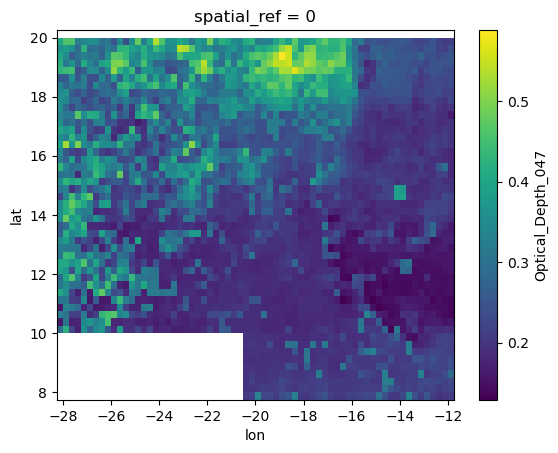

In [31]:
regridded_ds.std("time").Optical_Depth_047.T.plot()

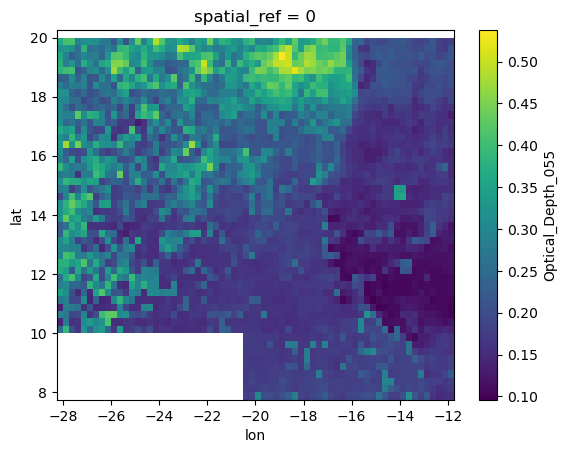

In [32]:
regridded_ds.std("time").Optical_Depth_055.T.plot()